# Environmental SetUp 

In [1]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

2024-04-05 15:38:17.958136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 15:38:17.958255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 15:38:18.095631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224

# EDA ON OUR DATASET

Total number of images: 23708
Sample Image path: 30_0_0_20170116223816127.jpg.chip.jpg
Sample Age: 30
Sample Gender: Male


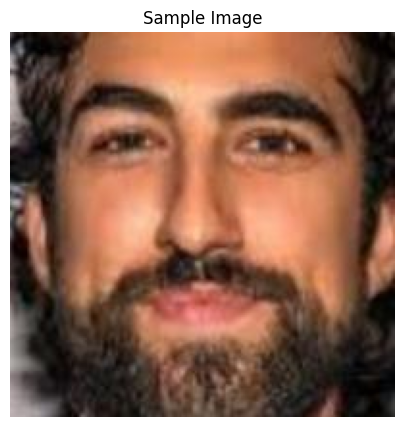

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Initialize the directory path
dir_path = "/kaggle/input/utkface-new/UTKFace/"
image_paths = os.listdir(dir_path)

# Initialize a Gender Mapping
gender_mapping = ["Male", "Female"]

# Choose and load an image randomly
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(dir_path + rand_image_path) / 255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print("Total number of images:", len(image_paths))
print("Sample Image path:", rand_image_path)
print("Sample Age:", sample_age)
print("Sample Gender:", gender_mapping[int(sample_gender)])

# Show the image
plt.figure(figsize=(5, 5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

In [14]:
# Initialize a male counter.
male_count = 0
ages = []

# Male counts
for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

# Count total female counts
female_count = len(image_paths) - male_count

In [15]:
import seaborn as sns

/tmp/ipykernel_34/2794015913.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ages)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

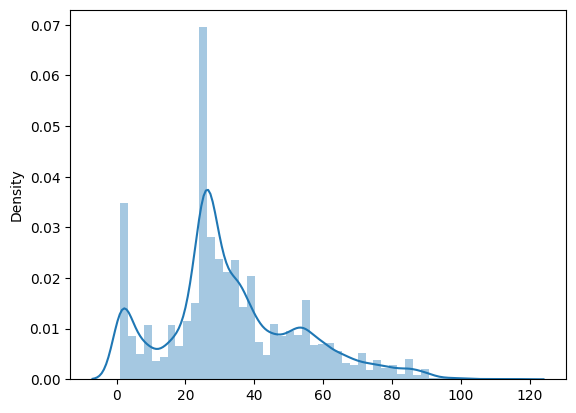

In [16]:
sns.distplot(ages)

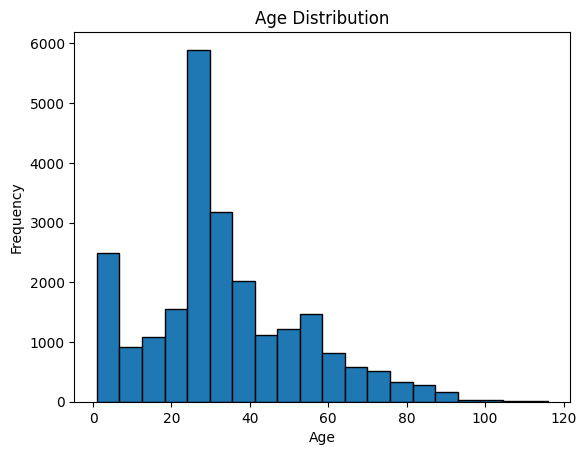

In [17]:
# Histogram of age
plt.hist(ages, bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

In [18]:
import plotly.express as px
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    title = "Gender Distribution Donut Chart",
    height = 500
)
pie_chart.show()

In [19]:
# SHuffling the Images
np.random.shuffle(image_paths)

# Split data into training, testing and validation set
train_images, test_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

train_images, valid_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")

# Extract age and gender
train_ages = [int(path.split("_")[0]) for path in train_images]
train_genders = [int(path.split("_")[1]) for path in train_images]

valid_ages = [int(path.split("_")[0]) for path in valid_images]
valid_genders = [int(path.split("_")[1]) for path in valid_images]

test_ages = [int(path.split("_")[0]) for path in test_images]
test_genders = [int(path.split("_")[1]) for path in test_images]

Training Size : 21337
Testing Size  : 2371


In [20]:
def preprocess_age_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, age

In [21]:
# Obtain training, testing and validation datasets
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [22]:
valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders)).shuffle(2000)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [23]:
test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

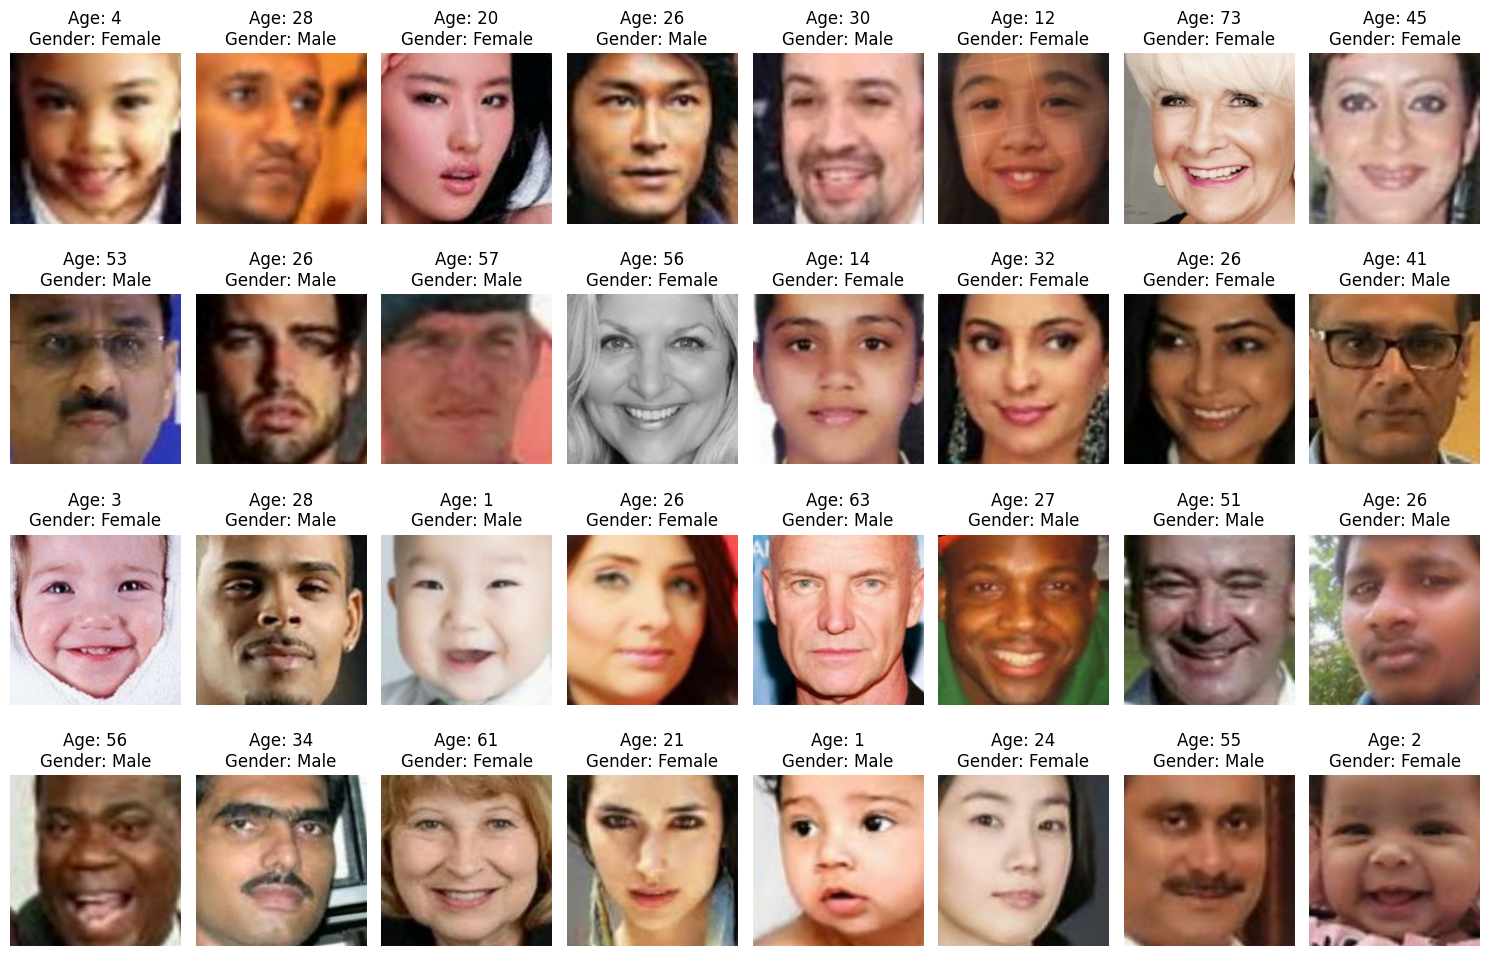

In [41]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(1):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}\nGender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

# RESNET50 Age Network 

In [32]:
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import InputLayer

In [33]:
input_shape = (224, 224, 3)

In [34]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [35]:
backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
model = Sequential()
model.add(backbone)
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu'))
optimizer = Adam(lr=0.0003)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

94765736/94765736 [==============================] - 4s 0us/step


In [36]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None


In [37]:
# Trining the Age Model
age_history =model.fit(
    train_age_ds,
    validation_data = valid_age_ds,
    epochs = 30,
    batch_size = BATCH_SIZE
)

Epoch 1/30


2024-04-05 15:43:42.044713: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1712331826.761488     516 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


667/667 [==============================] - 180s 216ms/step - loss: 8.8145 - mae: 8.8145 - val_loss: 21.4836 - val_mae: 21.4836
Epoch 2/30
667/667 [==============================] - 139s 209ms/step - loss: 7.1587 - mae: 7.1587 - val_loss: 7.2007 - val_mae: 7.2007
Epoch 3/30
667/667 [==============================] - 140s 209ms/step - loss: 6.5820 - mae: 6.5820 - val_loss: 8.4755 - val_mae: 8.4755
Epoch 4/30
667/667 [==============================] - 140s 210ms/step - loss: 6.0362 - mae: 6.0362 - val_loss: 7.5497 - val_mae: 7.5497
Epoch 5/30
667/667 [==============================] - 140s 209ms/step - loss: 5.6732 - mae: 5.6732 - val_loss: 6.4680 - val_mae: 6.4680
Epoch 6/30
667/667 [==============================] - 140s 209ms/step - loss: 5.4081 - mae: 5.4081 - val_loss: 8.5612 - val_mae: 8.5612
Epoch 7/30
667/667 [==============================] - 140s 209ms/step - loss: 5.1036 - mae: 5.1036 - val_loss: 6.2635 - val_mae: 6.2635
Epoch 8/30
667/667 [==============================] - 140

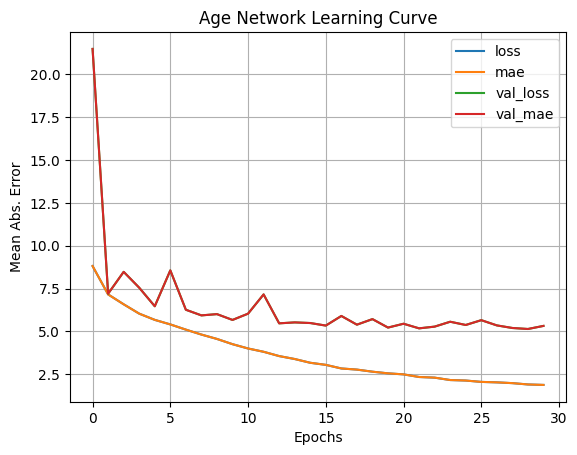

In [38]:
# Converting history into data frame.
age_his_df = pd.DataFrame(age_history.history)

# Visualization
age_his_df.plot()
plt.title("Age Network Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Mean Abs. Error")
plt.grid()
plt.show()

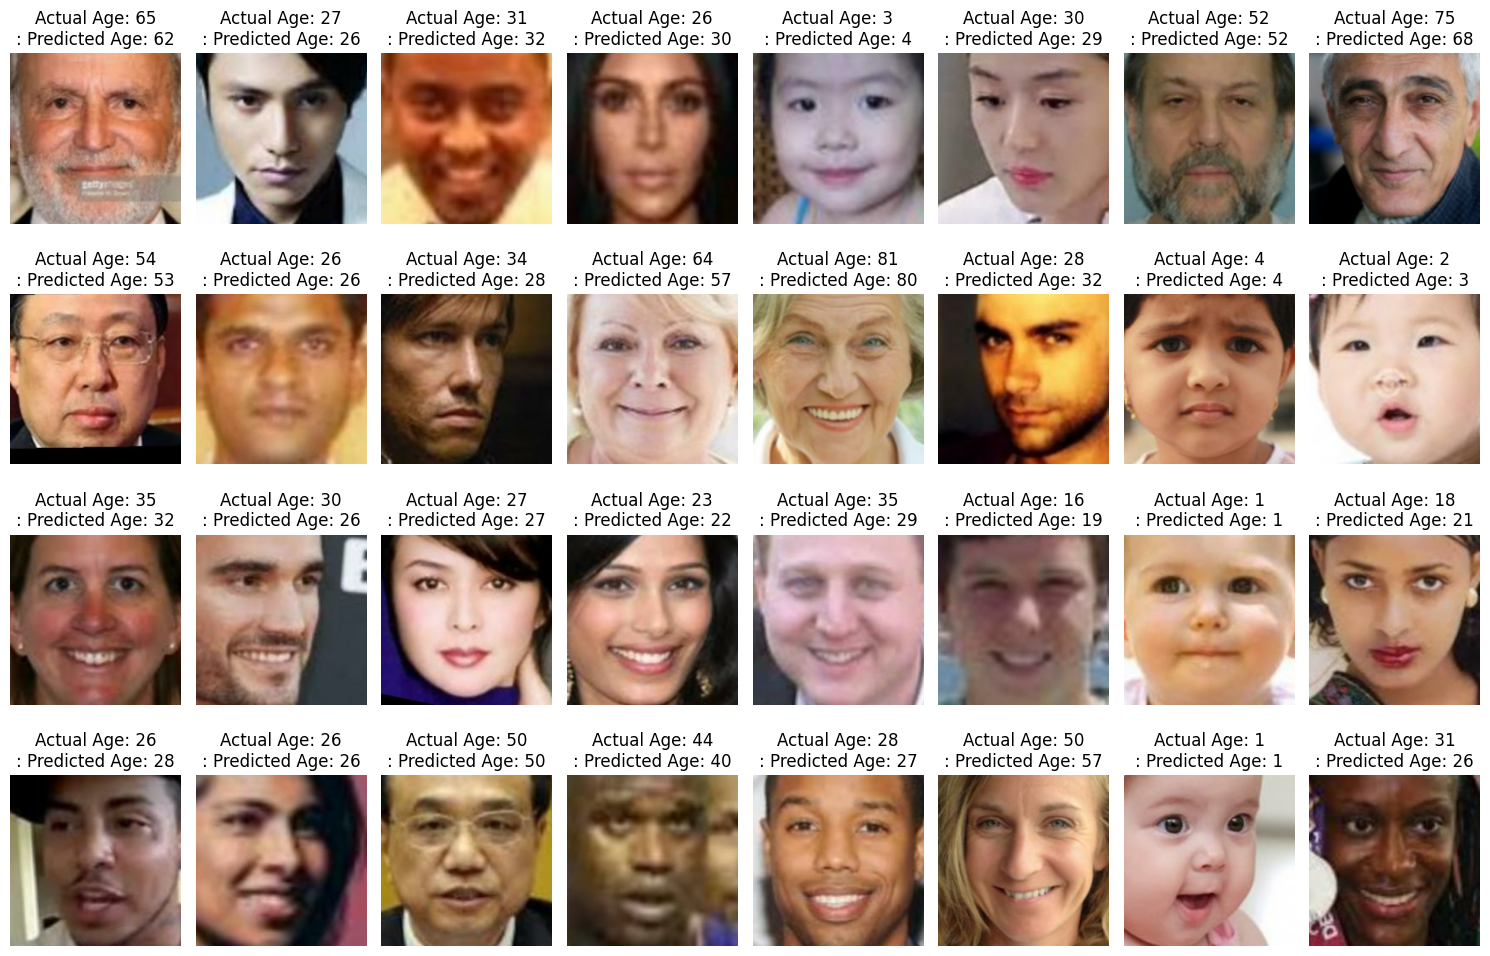

In [40]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(2):
    for index in range(len(images)):

        # Image Processing
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])
        
        # Predictions
        pred_age = tf.round(tf.squeeze(model.predict(image, verbose=0)), 2)

        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Actual Age: {ages[index]}\n: Predicted Age: {int(pred_age)}")
        plt.axis("off")

plt.tight_layout()
plt.show()